In [2]:
import numpy as np

In [394]:
import sys
sys.path.insert(1,'../../python/')

In [396]:
from utils import *

Define parameters for the QPM mocks:

In [399]:
class QPM_Parameters:
    """Holds covariance matrix parameters for the QPM matrices. These are initially set to default values"""
    def __init__(self,mock_no,mean=False):
        self.n=36
        self.m=10
        self.a=1
        self.n_indiv=10
        if mean:
            self.infile_root='/mnt/store1/oliverphilcox/CMU/QPM_MockMean/'
        else:
            self.infile_root='/mnt/store1/oliverphilcox/CMU/QPM_Covariances/Mock_%d/'%mock_no
        self.weights_file='/mnt/store1/oliverphilcox/CMU/weightfiles/jackknife_weights_n36_m10_j169.dat'
        self.RR_file = '/mnt/store1/oliverphilcox/CMU/weightfiles/binned_pair_counts_n36_m10_j169.dat'
        self.r_bins = np.loadtxt('../../python/binfile_linear.csv')         

Load the covariance matrix from the mean of the 1000 QPM Mocks

In [402]:
p=QPM_Parameters(0,mean=True)
p.n_indiv=40
qpm_mean=CovarianceMatrix(p)

Compute N_eff

In [401]:
qpm_mean.compute_N_eff()

Total N_eff Estimate: 1.544640e+06


1544640.2652509555

In [405]:
qpm_mean.compute_precision()

General KL divergence function:

In [128]:
def KL_divergence(precision,covariance):
    """Return the negative log likelihood of the KL divergence between two matrices, one of which is inverted.
    The matrix known to higher precision should be inverted.
    i.e. 2KL = Trace(precision*covariance) - log(det(precision)) - log(det(covariance)) - N_bins"""
    product = np.matmul(precision,covariance);
    N_bins=len(precision)
    logdetPrec = np.linalg.slogdet(precision)
    logdetCov = np.linalg.slogdet(covariance)
    if logdetPrec[0]!=1.:
        raise Exception('Undefined determinant for precision matrix')
    if logdetCov[0]!=1.:
        raise Exception('Undefined determinant for covariance matrix')
    KL = 0.5*(np.matrix.trace(product) - logdetPrec[1] - logdetCov[1] - N_bins)
    return KL

Compute KL divergence between $\psi$ from all mocks and $C$ for each mock (run for 15 minutes each, with $N_\mathrm{eff}\sim4\times10^4$.

In [186]:
KL_divs=[]
for i in range(1,24):
    p_QPM=QPM_Parameters(i)
    this_covariance=CovarianceMatrix(p_QPM)
    KL_divs.append(KL_divergence(qpm_mean.prec,this_covariance.c_tot))

Compute $|C_{[i]}|$ per bin for each QPM mock matrix:

In [403]:
det_bin=[]
for i in range(1,24):
    p_QPM=QPM_Parameters(i)
    this_covariance=CovarianceMatrix(p_QPM)
    det_bin.append(np.exp(np.linalg.slogdet(this_covariance.c_tot)[1]/len(this_covariance.c_tot)))

In [200]:
det_mean = np.exp(np.linalg.slogdet(qpm_mean.c_tot)[1]/len(qpm_mean.c_tot))

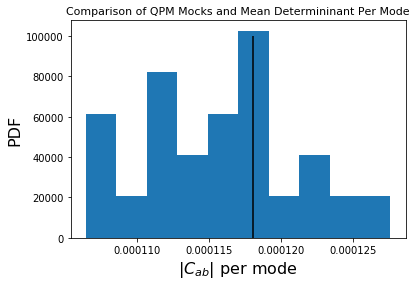

In [208]:
plt.hist(det_bin,density=True);FS=16
plt.vlines(det_mean,0,100000);plt.title('Comparison of QPM Mocks and Mean Determininant Per Mode',fontsize=FS-5)
plt.ylabel('PDF',fontsize=FS);plt.xlabel(r'$|C_{ab}|$ per mode',fontsize=FS);

In [425]:
mean=np.mean(det_bin)

In [426]:
std=np.std(det_bin)/np.sqrt(len(det_bin))

In [428]:
det_mean-mean

2.4760296741409467e-06

In [429]:
mean

0.00011562105709158891

In [427]:
(det_mean-mean)/std

2.1639861665715223

In [ ]:
det_mean-np.

Also compute $|\psi\times{}C_{[i]}-I|$ for each mock: 

In [417]:
iden_bin=[]
for i in range(1,24):
    p_QPM=QPM_Parameters(i)
    this_covariance=CovarianceMatrix(p_QPM)
    product=np.matmul(qpm_mean.prec,this_covariance.c_tot)#-np.eye(len(qpm_mean.prec))
    iden_bin.append(np.exp(np.linalg.slogdet(product)[1]/len(product))-1)

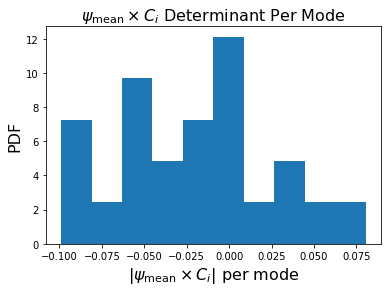

In [418]:
plt.hist(iden_bin,density=True);FS=16
#plt.vlines(0.,0,100000);
plt.title(r'$\psi_\mathrm{mean}\times{}C_i$ Determinant Per Mode',fontsize=FS)
plt.ylabel('PDF',fontsize=FS);plt.xlabel(r'$|\psi_\mathrm{mean}\times{}C_i|$ per mode',fontsize=FS);

In [419]:
np.std(iden_bin)/np.sqrt(len(iden_bin))

0.009685557440814965

In [420]:
np.mean(iden_bin)

-0.021276104453939695

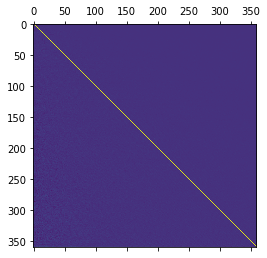

In [421]:
plt.matshow(product-np.eye())

Compare mock matrix with same run for twice as long:

In [434]:
p_QPM=QPM_Parameters(1)
cov_single=CovarianceMatrix(p_QPM)
N_single=cov_single.compute_N_eff()
KL_div_single=KL_divergence(qpm_mean.prec,cov_single.c_tot)
p_QPM.infile_root='/mnt/store1/oliverphilcox/CMU/QPM_Covariances2/Mock_1/'
p_QPM.n_indiv=20
cov_double=CovarianceMatrix(p_QPM)
KL_div_double=KL_divergence(qpm_mean.prec,cov_double.c_tot)
N_double=cov_double.compute_N_eff()

Total N_eff Estimate: 5.452866e+04
Total N_eff Estimate: 1.066560e+05


In [435]:
print(N_single,N_double)

54528.66451856861 106656.02886003398


In [436]:
print(KL_div_single,KL_div_double)
print(KL_div_single*(N_single/N_double))

0.895494456999586 0.5303386847235743
0.4578280041538819


Now compute $N_\mathrm{eff}$ and $D_{KL}$ for each estimate of the matrix for a single mock;

In [440]:
partial_covs_indiv=[]
p_QPM=QPM_Parameters(1)
p_QPM.infile_root='/mnt/store1/oliverphilcox/CMU/QPM_Covariances2/Mock_1/'
qpm_1=CovarianceMatrix(p_QPM)
i_min=3;i_max=20
for i in range(i_max):
    partial_covs_indiv.append(qpm_1.read_all_matrices(root=str(i)))
N_effs_indivs=np.zeros(i_max-i_min)
KL_div_indivs=np.zeros(i_max-i_min)
samples_indivs=np.arange(i_min,i_max)
for ii in range(i_min,i_max):
    c_tot_mats=partial_covs_indiv[:ii]
    nn = len(c_tot_mats)
    summ=0.
    for i in range(nn):
        c_excl_i = np.mean(c_tot_mats[:i]+c_tot_mats[i+1:],axis=0)
        summ+=np.matmul(np.linalg.inv(c_excl_i),c_tot_mats[i])
    D_est = (nn-1.)/nn*(-1.*np.eye(len(c_tot_mats[0]))+1./nn*summ)
    slogdetD=np.linalg.slogdet(D_est)
    n_bins = len(D_est)
    D_value = slogdetD[0]*np.exp(slogdetD[1]/n_bins)
    N_effs_indivs[ii-i_min] = (n_bins+1.)/D_value+1.
    KL_div_indivs[ii-i_min] = KL_divergence(qpm_mean.prec,np.mean(c_tot_mats,axis=0))

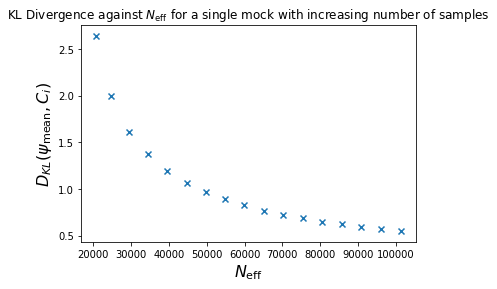

In [441]:
plt.scatter(N_effs_indivs,KL_div_indivs,marker='x');
plt.ylabel(r'$D_{KL}(\psi_\mathrm{mean},C_i)$',fontsize=16);plt.xlabel(r'$N_\mathrm{eff}$',fontsize=16)
plt.title(r'KL Divergence against $N_\mathrm{eff}$ for a single mock with increasing number of samples');

Compute the relevant $N_\mathrm{eff}$ from this:

In [442]:
N_bins = len(qpm_mean.prec)
n_eff_KL_indiv=[N_bins*(N_bins+1)/(4.*KL) for KL in KL_div_indivs]

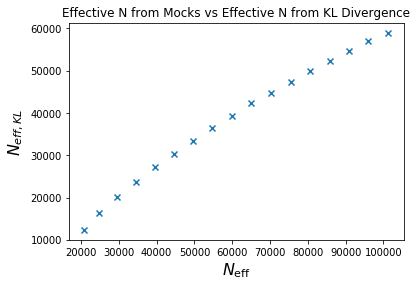

In [443]:
plt.scatter(N_effs_indivs,n_eff_KL_indiv,marker='x');
plt.ylabel(r'$N_{eff,KL}$',fontsize=16);plt.xlabel(r'$N_\mathrm{eff}$',fontsize=16)
plt.title(r'Effective N from Mocks vs Effective N from KL Divergence');

In [187]:
N_bins = len(qpm_mean.prec)
n_eff_KL=[N_bins*(N_bins+1)/(4.*KL) for KL in KL_divs]

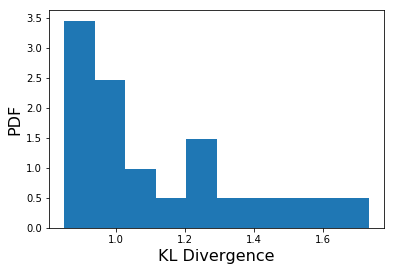

In [195]:
plt.hist(KL_divs,density=True);
plt.ylabel('PDF',fontsize=16);plt.xlabel('KL Divergence',fontsize=16);

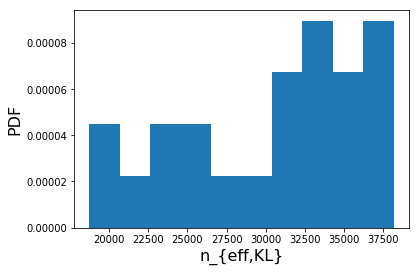

In [196]:
plt.hist(n_eff_KL,density=True); plt.ylabel('PDF',fontsize=16);plt.xlabel('n_{eff,KL}',fontsize=16);

In [275]:
precs=[]
for i in range(1,23):
    p_QPM=QPM_Parameters(i)
    qpm=CovarianceMatrix(p_QPM)
    qpm.compute_N_eff()
    qpm.compute_precision()
    precs.append(qpm.prec)

Total N_eff Estimate: 5.452866e+04
Total N_eff Estimate: 5.448725e+04


KeyboardInterrupt: 

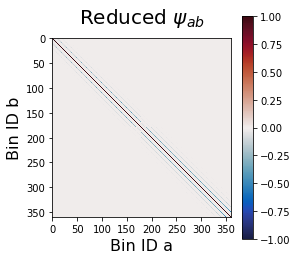

In [190]:
pt=plotting_tools()
pt.plot_reduced_precision(qpm_mean)#,50,100)

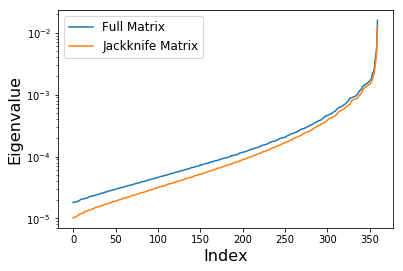

In [192]:
pt=plotting_tools()
pt.plot_eigenvalues(qpm_mean)

In [210]:
p_QPM=QPM_Parameters(1)
this_covariance=CovarianceMatrix(p_QPM)

Compute N_eff against samples for the mean of the mocks and the individual estimates - does this plateau?

In [465]:
N_effs_indivs_all=[]
for index in range(1,20):
    partial_covs_indiv=[]
    p_QPM=QPM_Parameters(index)
    qpm_1=CovarianceMatrix(p_QPM)
    for i in range(10):
        partial_covs_indiv.append(qpm_1.read_all_matrices(root=str(i)))
    i_min=3;i_max=10
    N_effs_indivs=np.zeros(i_max-i_min)
    samples_indivs=np.arange(i_min,i_max)
    for ii in range(i_min,i_max):
        c_tot_mats=partial_covs_indiv[:ii]
        nn = len(c_tot_mats)
        summ=0.
        for i in range(nn):
            c_excl_i = np.mean(c_tot_mats[:i]+c_tot_mats[i+1:],axis=0)
            summ+=np.matmul(np.linalg.inv(c_excl_i),c_tot_mats[i])
        D_est = (nn-1.)/nn*(-1.*np.eye(len(c_tot_mats[0]))+1./nn*summ)
        slogdetD=np.linalg.slogdet(D_est)
        n_bins = len(D_est)
        D_value = slogdetD[0]*np.exp(slogdetD[1]/n_bins)
        N_effs_indivs[ii-i_min] = (n_bins+1.)/D_value+1.
    N_effs_indivs_all.append(np.asarray(N_effs_indivs))

KeyboardInterrupt: 

In [271]:
partial_covs=[]
for i in range(40):
    partial_covs.append(qpm_mean.read_all_matrices(root=str(i)))

In [466]:
i_min=5;i_max=40
N_effs=np.zeros(i_max-i_min)
samples_all=np.arange(i_min,i_max)
for ii in range(i_min,i_max):
    
    
    c_tot_mats=partial_covs[:ii]
    nn = len(c_tot_mats)
    summ=0.
    for i in range(nn):
        c_excl_i = np.mean(c_tot_mats[:i]+c_tot_mats[i+1:],axis=0)
        summ+=np.matmul(np.linalg.inv(c_excl_i),c_tot_mats[i])
    D_est = (nn-1.)/nn*(-1.*np.eye(len(c_tot_mats[0]))+1./nn*summ)
    slogdetD=np.linalg.slogdet(D_est)
    n_bins = len(D_est)
    D_value = slogdetD[0]*np.exp(slogdetD[1]/n_bins)
    N_effs[ii-i_min] = (n_bins+1.)/D_value+1.

In [467]:
mean_N_effs=[np.mean([N[i] for N in N_effs_indivs_all]) for i in range(len(N_effs_indivs_all[0]))]
std_N_effs=[np.std([N[i] for N in N_effs_indivs_all]) for i in range(len(N_effs_indivs_all[0]))]

In [468]:
n_quads_tot=np.loadtxt('/mnt/store1/oliverphilcox/CMU/QPM_MockMean/CovMatricesAll/total_counts_n36_m10_11,11.txt')[-1]    

In [469]:
samples_indivs

array([3, 4, 5, 6, 7, 8, 9])

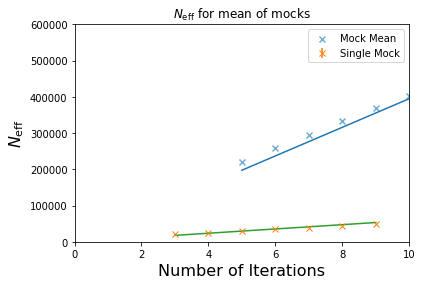

In [470]:
plt.scatter(samples_all,N_effs,alpha=0.6,marker='x',label='Mock Mean')
plt.plot(samples_all,samples_all*np.mean(N_effs/samples_all))
plt.errorbar(samples_indivs,mean_N_effs,yerr=std_N_effs,label='Single Mock',ls='',marker='x')
plt.plot(samples_indivs,samples_indivs*np.mean(mean_N_effs/samples_indivs))
plt.xlim([0,10])
plt.ylim([0,600000])
plt.ylabel(r'$N_\mathrm{eff}$',fontsize=16)
plt.legend();#plt.yscale('log');plt.xscale('log')
plt.xlabel('Number of Iterations',fontsize=16);plt.title(r'$N_\mathrm{eff}$ for mean of mocks');

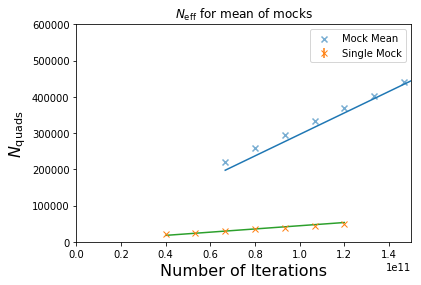

In [486]:
fac=n_quads_tot/max(samples_all)
n_quad_s=samples_all*fac
plt.scatter(n_quad_s,N_effs,alpha=0.6,marker='x',label='Mock Mean')
plt.plot(n_quad_s,n_quad_s*np.mean(N_effs/n_quad_s))
plt.errorbar(samples_indivs*fac,mean_N_effs,yerr=std_N_effs,label='Single Mock',ls='',marker='x')
plt.plot(samples_indivs*fac,samples_indivs*fac*np.mean(mean_N_effs/(fac*samples_indivs)))
plt.ylabel(r'$N_\mathrm{quads}$',fontsize=16)
plt.xlim([0,1.5e11])
plt.ylim([0,6e5])
plt.legend();#plt.yscale('log');plt.xscale('log')
plt.xlabel('Number of Iterations',fontsize=16);plt.title(r'$N_\mathrm{eff}$ for mean of mocks');

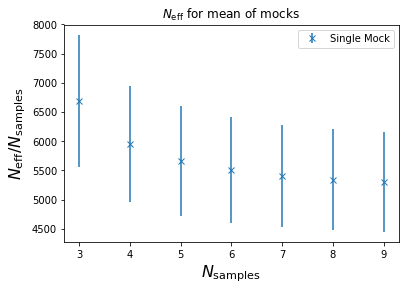

In [358]:
#plt.scatter(samples_all,N_effs,alpha=0.6,marker='x',label='Mock Mean')
#plt.plot(samples_all,samples_all*np.mean(N_effs/samples_all))
plt.errorbar(samples_indivs,mean_N_effs/samples_indivs,yerr=std_N_effs/samples_indivs,label='Single Mock',ls='',marker='x')
#plt.plot(samples_indivs,samples_indivs*np.mean(mean_N_effs/samples_indivs))
plt.ylabel(r'$N_\mathrm{eff}/N_\mathrm{samples}$',fontsize=16)
plt.legend();#plt.yscale('log');plt.xscale('log')
plt.xlabel(r'$N_\mathrm{samples}$',fontsize=16);plt.title(r'$N_\mathrm{eff}$ for mean of mocks');